[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/v0.6.2/docs/visualization_tutorial.ipynb)

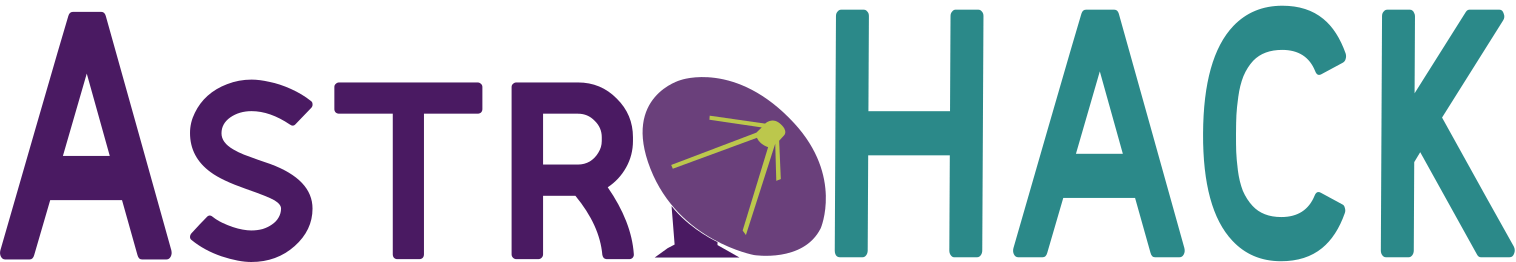

# Holography Visualization Tutorial

This visualization tutorial uses the same dataset that is used on the VLA tutorial.
If the VLA tutorial has been previously run on the same directory the data will be re-utilized.

In [1]:
import os

try:
    import astrohack
    
    print('AstroHACK version', astrohack.__version__, 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', astrohack.__version__, ' installed.')

AstroHACK version 0.6.2 already installed.


In [2]:
# Convenience function:
import glob
def list_directory_files(path):
    try:
        for entry in glob.glob(path):
            print(entry)
    except FileNotFoundError:
        print(f'{path} not found.')

## Download Tutorial Data and spawning an Astrohack Client

If the VLA data cannot be found in the specified directory it will be downloaded.
The Astrohack client is spawned so that parallel processing is possible further down.

In [3]:
import toolviper

from toolviper.dask import menrva
from toolviper.dask.client import local_client

ms_name = 'data/ea25_cal_small_after_fixed.split.ms'
toolviper.utils.data.download(file='ea25_cal_small_after_fixed.split.ms', folder='data')

client = local_client(cores=4, memory_limit='1GB')
client

[2025-03-26 16:11:35,629]     INFO   astrohack:  Checking functions availability: 


[2025-03-26 16:11:35,630]     INFO   astrohack:  Loading module: slurm -- Success 


[2025-03-26 16:11:35,630]     INFO   astrohack:     dask_jobqueue is available 


[2025-03-26 16:11:35,631]     INFO   astrohack:  Loading module: dask_ssh -- Fail 


[2025-03-26 16:11:35,632]     INFO   astrohack:     asyncssh is unavailable 


[2025-03-26 16:11:35,633]     INFO   astrohack:     jupyter_server_proxy is unavailable 


[2025-03-26 16:11:35,633]     INFO   astrohack:     paramiko is unavailable 


[2025-03-26 16:11:35,634]     INFO   astrohack:  Loading module: CUDA -- Fail 


[2025-03-26 16:11:35,635]     INFO   astrohack:     dask_cuda is unavailable 


[2025-03-26 16:11:35,636]     INFO   astrohack:  Available functions of this environment: slurm 


[2025-03-26 16:11:35,637]  WARNING   astrohack:  File exists: /home/victor/mambaforge/envs/casadev/lib/python3.12/site-packages/toolviper/utils/data/.dropbox 


[2025-03-26 16:11:35,638]     INFO   astrohack:  Updating file metadata information ...  


 Download List                        
 ───────────────────────────────────── 
  ea25_cal_small_after_fixed.split.ms

[2025-03-26 16:11:36,627]     INFO   astrohack:  File exists: data/ea25_cal_small_after_fixed.split.ms 


[2025-03-26 16:11:36,628]     INFO   astrohack:  Module path: /home/victor/mambaforge/envs/casadev/lib/python3.12/site-packages/toolviper 


[2025-03-26 16:11:36,636]  WARNING   astrohack:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 


[2025-03-26 16:11:38,405]     INFO   astrohack:  Client <MenrvaClient: 'tcp://127.0.0.1:40009' processes=4 threads=4, memory=3.73 GiB> 


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40009,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:45131,Total threads: 1
Dashboard: http://127.0.0.1:33699/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:45735,


In [4]:
client.dashboard_link

'http://127.0.0.1:8787/status'

## Extract_holog: checking data calibration

Astrohack requires the measurement set (MS) that is fed into `extract_holog` to be properly calibrated in CASA.
To check that calibration is sound, a method has been implemented in the `holog_mds` class that plots the visibilities at the center of the beam.

### Run extract_holog or open a holog file

Prior to plotting the diagnostic plots it is necessary to create a `holog_mds` object (holography Multi DataSet). This Object can be created by running `extract_holog`, or by opening the data products of `extract_holog` with the function `open_holog`.
Here `extract_holog` is executed if a previously produced `.holog.zarr` file is not found.

In [5]:
import os

from astrohack import extract_holog
from astrohack import extract_pointing

from astrohack.dio import open_holog

point_name = 'data/ea25_cal_small_after_fixed.split.point.zarr'
extract_pointing(
      ms_name=ms_name,
      point_name=point_name,
      parallel=True,
      overwrite=True
)

holog_file = 'data/ea25_cal_small_after_fixed.split.holog.zarr'

if os.path.exists(holog_file):
    holog_mds = open_holog(holog_file)
else:
    holog_mds = extract_holog(      
        ms_name=ms_name, 
        point_name=point_name,
        data_column='CORRECTED_DATA', 
        parallel=True,
        overwrite=True
    )

[2025-03-26 16:11:38,440]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


[2025-03-26 16:11:38,444]  WARNING   astrohack:  data/ea25_cal_small_after_fixed.split.point.zarr will be overwritten. 


[2025-03-26 16:11:44,834]     INFO   astrohack:  Finished processing 


### Generate holography dictionary

The function `extract_holog` creates a fully formed observation dictionary by default but can also take a user specified observation dictionary via the input parameter, `holog_obs_dict`. To help with this the user function `generate_holo_obs_dict` is provided to generate and return the full dictionary to the user for subselection and modification.

In [6]:
from astrohack.extract_holog import generate_holog_obs_dict

holog_obs_dict = generate_holog_obs_dict(
    ms_name='data/ea25_cal_small_after_fixed.split.ms',
    point_name='data/ea25_cal_small_after_fixed.split.point.zarr',
    parallel=False
)

[2025-03-26 16:11:44,919]     INFO   astrohack:  Writing distance matrix to /home/victor/work/Holography-1022/astrohack/docs/.baseline_distance_matrix.csv ... 


### Inspect holography dictionary

Generally the printing a nested dictionary such as the `holog_obs_dict` is a messy, ugly affair and for this reason an additional convenience ffunction has been added to inspect the output dictionary, `inspect_holog_ocs_dict`. 

This function has two modes:

**static mode** - Static mode is a formatted string output and allows the user to define how the antenna dictionary list is handled. By adjusting the columns input variable the user can for instance take an scan list of length of 15 and display it as 3 rows of 5 columns (this would be columns=5). The reshaping code will look at the list and reshape it even if the length is not an exact split, ie. length =17 with columns=5 would give 4 rows as output with the last row being the remainders.

**dynamic mode** - Dynamic mode returns a collapsible json dictionary in the cell so that the user can look at only certain parts of large holog dictionaries.

The function accepts both `json` objects and json files as input.

In [7]:
from astrohack.dio import inspect_holog_obs_dict

inspect_holog_obs_dict(file=holog_obs_dict, style='static')

[16:11:44] {                                                                                             ]8;id=285141;file:///home/victor/work/Holography-1022/astrohack/src/astrohack/dio.py\dio.py]8;;\:]8;id=223691;file:///home/victor/work/Holography-1022/astrohack/src/astrohack/dio.py#430\430]8;;\
               'ddi_0': {                                                                                          
                   'map_0': {                                                                                      
                       'scans': [                                                                                  
                           8,                                                                                      
                           9,                                                                                      
                           10,                                                                                     
                           12,                                                                                     
                           13,                                                                                     
                           14,                                                                                     
                           16,                                                                                     
                           17,                                                                                     
                           18,                                                                                     
                           23,                                                                                     
                           24,                                                                                     
                           25,                                                                                     
                           27,                                                                                     
                           28,                                                                                     
                           29,                                                                                     
                           31,                                                                                     
                           32,                                                                                     
                           33,                                                                                     
                           38,                                                                                     
                           39,                                                                                     
                           40,                                                                                     
                           42,                                                                                     
                           43,                                                                                     
                           44,                                                                                     
                           46,                                                                                     
                           47,                                                                                     
                           48,                                                                                     
                           53,                                                                                     
                           54,                                                                  

In [8]:
inspect_holog_obs_dict(file=holog_obs_dict, style='dynamic')

<IPython.core.display.JSON object>

It is also possible to inpect the holog observation dictionary that was used by `extract_holog` while processing an MS. This is useful to check which antenna(s) was(were) picked as reference antenna.

In [9]:
inspect_holog_obs_dict(file=holog_file, style='dynamic')

<IPython.core.display.JSON object>

Now that we have a `holog_mds` object we define a variable `holog_exports` with the name of the directory to contain our diagnostic plots. We can also inspect our `holog_mds` object by calling its `summary` method. This method lists the attributes of the `holog_mds`, such as the input `MS` and the inputs given by the user, but more important for us going forward, it also gives us a summary of the data contents in the `holog_mds` and its available methods, here we are going to use the `plot_diagnostics` and `plot_lm_sky_coverage` methods.

In [10]:
holog_exports = 'holog_exports'
holog_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.holog.zarr                       ###
####################################################################################################

Full documentation for AstrohackHologFile objects' API at: 
https://astrohack.readthedocs.io/en/stable/_api/autoapi/astrohack/mds/index.html#astrohack.mds.AstrohackHologFile

Input Parameters:
+---------------------------+--------------------------------------------------+
| Parameter                 | Value                                            |
+---------------------------+--------------------------------------------------+
| ms_name                   | data/ea25_cal_small_after_fixed.split.ms         |
| point_name                | data/ea25_cal_small_after_fixed.split.point.zarr

### Calibration diagnostic plots

Below is a call to `plot_diagnostics`, we limit our plotting to only DDI 0 of antenna ea25 for simplicity. The plot shown here displays the Amplitudes and phases for RR and LL correlations at the beam center for all channels. With this plots we want to make sure that the Amplitudes remain close to 1, and that the phase remains close to 0. The data displayed here is well calibrated but displays the Gibbs phenomenon at the band edges which is normal.

[2025-03-26 16:11:44,989]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


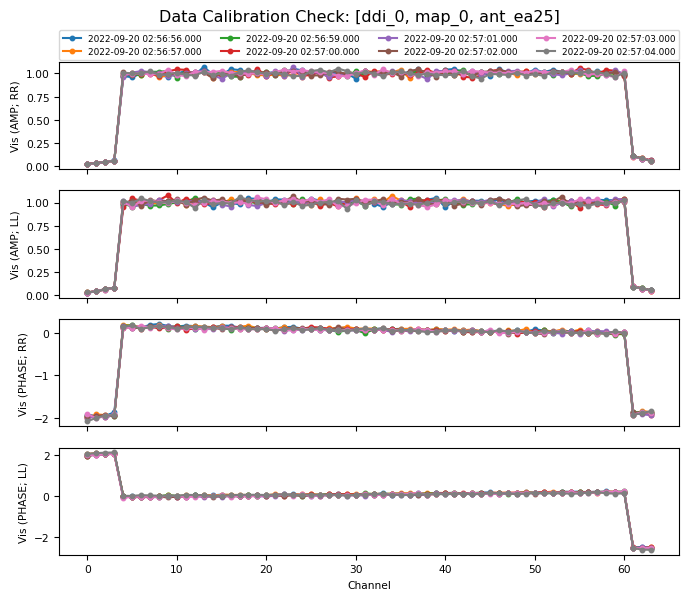

In [11]:
holog_mds.plot_diagnostics(
    holog_exports,         # Directory to contain the plots
    ant='ea25',            # Plotting antenna ea25
    ddi=0,                 # Plotting DDI 0
    map_id="all",          # Plotting all mappings
    complex_split='polar', # Split complex data to polar (amplitude + phase)
    display=True,          # Display results in Notebook cell
    parallel=False         # Don't plots in parallel
)        

Below we call `plot_diagnostics` again but this time over all the antennas and DDIs in the `holog_mds`. As before the created plots are stored in `holog_exports` but this time they are not displayed for brevity. All the files created by `plot_diagnostics` can be seen just after its execution.

In [12]:
holog_mds.plot_diagnostics(
    holog_exports,             # Directory to contain the plots
    ant="all",                 # Plotting all antennas
    ddi="all",                 # Plotting all DDIs
    map_id="all",              # Plotting all mappings
    complex_split='cartesian', # Split comples data to cartesian (real + imaginary)
    display=False,             # don't display results in Notebook cell
    parallel=True              # Do plots in parallel
)             

# All exported files
print('\nCreated files:')

list_directory_files(holog_exports+'/holog_diagnostics*.png')

[2025-03-26 16:11:47,588]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 



Created files:
holog_exports/holog_diagnostics_map_0_ant_ea06_ddi_0.png
holog_exports/holog_diagnostics_map_0_ant_ea25_ddi_1.png
holog_exports/holog_diagnostics_map_0_ant_ea25_ddi_0.png
holog_exports/holog_diagnostics_map_0_ant_ea06_ddi_1.png


### Directional cosines sky coverage

Below is a call to `plot_lm_sky_coverage`, we limit our plotting to only DDI 0 of antenna ea25 for simplicity. The plot shown here displays the sky coverage of the L and M axes. Also displayed are the Amplitudes and phases for the RR correlation as a function of the L, M and time axes.
These plots help us in identifying problems with the pointing data in the MS, and or problems in the visibility data that vary with the L, M or time axes.

[2025-03-26 16:11:51,777]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


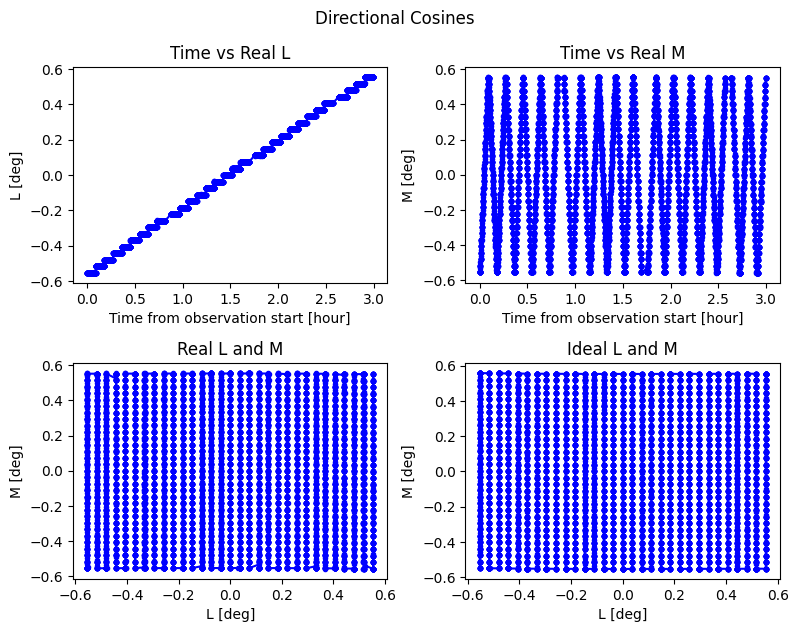

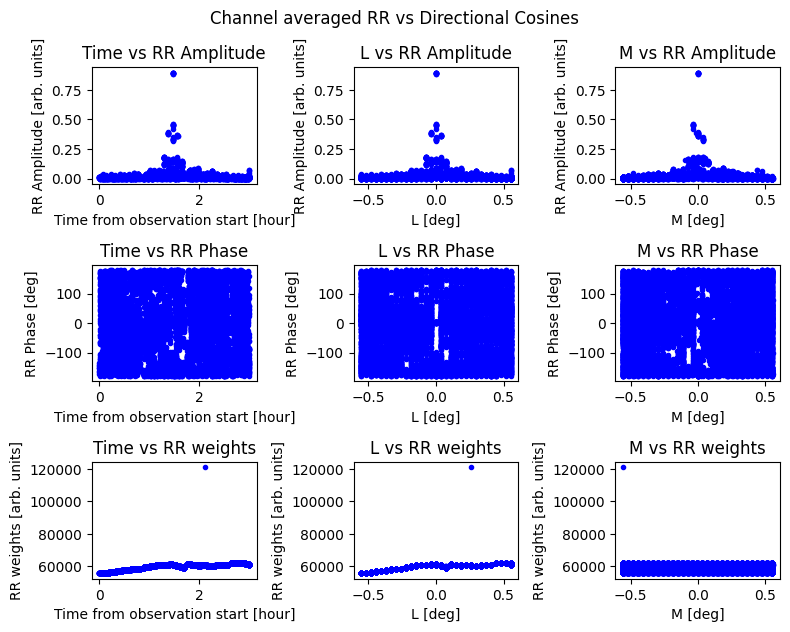

In [13]:
holog_mds.plot_lm_sky_coverage(
    holog_exports,          # Directory to contain the plots
    ant='ea25',             # Plotting antenna ea25
    ddi=0,                  # Plotting DDI 0
    map_id="all",           # Plotting all mappings
    angle_unit='deg',       # Unit for L and M axes
    time_unit='hour',       # Time unit
    plot_correlation='RR',  # Which correlation to be plotted
    complex_split='polar',  # Split comples data to polar (Amplitude + phase)
    phase_unit='deg',       # Unit for phase
    display=True,           # Display plots bellow
    parallel=False          # Do not do plots in parallel
)

Below we call `plot_lm_sky_coverage` again but this time over all the antennas and DDIs in the `holog_mds`. As before the created plots are stored in `holog_exports` but this time they are not displayed for brevity. All the files created by `plot_lm_sky_coverage` can be seen just after its execution.                  

In [14]:
holog_mds.plot_lm_sky_coverage(
    holog_exports,          # Directory to contain the plots
    ant="all",              # Plotting all antennas
    ddi="all",              # Plotting all DDIs
    map_id="all",           # Plotting all mappings
    angle_unit='deg',       # Unit for L and M axes
    time_unit='hour',       # Time unit
    plot_correlation='all', # Plot all corellations
    complex_split='polar',  # Split comples data to cartesian (real + imaginaty)
    phase_unit='deg',       # Unit for phase
    display=False,          # Do not display plots bellow
    parallel=True           # Do plots in parallel
)

# All exported files
print('\nCreated files:')

list_directory_files(holog_exports+'/holog_directional_cosines*.png')

[2025-03-26 16:11:56,363]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 



Created files:
holog_exports/holog_directional_cosines_map_0_ant_ea06_ddi_1.png
holog_exports/holog_directional_cosines_LL_map_0_ant_ea25_ddi_1.png
holog_exports/holog_directional_cosines_RR_map_0_ant_ea06_ddi_0.png
holog_exports/holog_directional_cosines_LR_map_0_ant_ea06_ddi_1.png
holog_exports/holog_directional_cosines_RL_map_0_ant_ea06_ddi_1.png
holog_exports/holog_directional_cosines_RL_map_0_ant_ea25_ddi_1.png
holog_exports/holog_directional_cosines_LR_map_0_ant_ea25_ddi_0.png
holog_exports/holog_directional_cosines_LL_map_0_ant_ea06_ddi_1.png
holog_exports/holog_directional_cosines_map_0_ant_ea25_ddi_1.png
holog_exports/holog_directional_cosines_map_0_ant_ea25_ddi_0.png
holog_exports/holog_directional_cosines_RR_map_0_ant_ea25_ddi_0.png
holog_exports/holog_directional_cosines_map_0_ant_ea06_ddi_0.png
holog_exports/holog_directional_cosines_LL_map_0_ant_ea25_ddi_0.png
holog_exports/holog_directional_cosines_RL_map_0_ant_ea25_ddi_0.png
holog_exports/holog_directional_cosines_RL_m

## Holog: Checking beam and aperture quality and exporting data to FITS files

After we are sure about the quality of the calibrated data in the `MS` we want to make sure that the beam is well sampled and behaved and that the apertures are well characterised and have enough resolution. For that we are going to use the methods of the `image_mds` object, i.e. the data product of the `holog` function.

### Run holog or open image file

Like before with the `.holog.zarr` file, if the `.image.zarr` is available we simply open it with `open_image`, otherwise we run `holog` to obtain our `image_mds` object.

In [15]:
import os
from astrohack import holog, open_image

image_file = 'data/ea25_cal_small_after_fixed.split.image.zarr'

if os.path.exists(image_file):
    image_mds = open_image(image_file)
else:
    image_mds = holog(
        holog_name=holog_file,
        overwrite=True,
        phase_fit=True,
        to_stokes=True,
        parallel=True
)


Now that we have a `image_mds` object we define a variable called `image_exports` with the name of the directory to contain our plots and exported FITS files. We can also inspect our `image_mds` object by calling its `summary` method. Like for the `holog_mds` object, this method lists the attributes of the `image_mds`, such as the input `.holog.zarr` file and the inputs given by the user, like before we are actually interested on  the data contents and the available methods. For this tutorial the relevant methods are `plot_beams`, `plot_apertures` and `export_to_fits`.

In [16]:
image_exports = 'image_exports'
image_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.image.zarr                       ###
####################################################################################################

Full documentation for AstrohackImageFile objects' API at: 
https://astrohack.readthedocs.io/en/stable/_api/autoapi/astrohack/mds/index.html#astrohack.mds.AstrohackImageFile

Input Parameters:
+-------------------------+--------------------------------------------------+
| Parameter               | Value                                            |
+-------------------------+--------------------------------------------------+
| holog_name              | data/ea25_cal_small_after_fixed.split.holog.zarr |
| grid_size               | None                                             |
| cell_

### Plotting beams

Here we make a call to `plot_beams` to plot the beam for a single antenna and DDI for brevity. These plots tell us about the shape of the beam, i.e. is it circular? is it smeared?

[2025-03-26 16:12:07,325]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


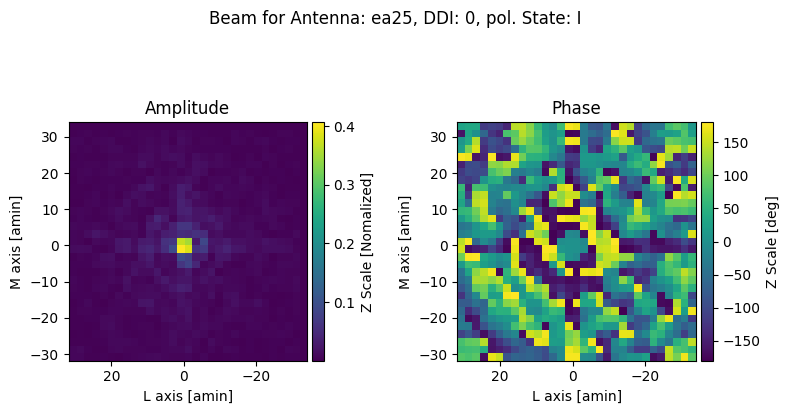

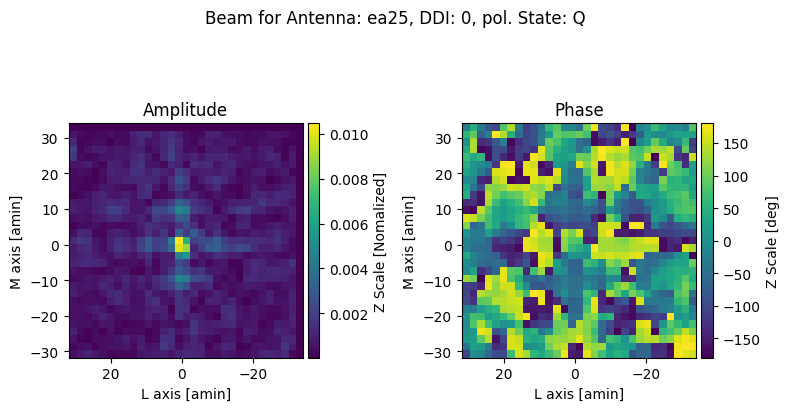

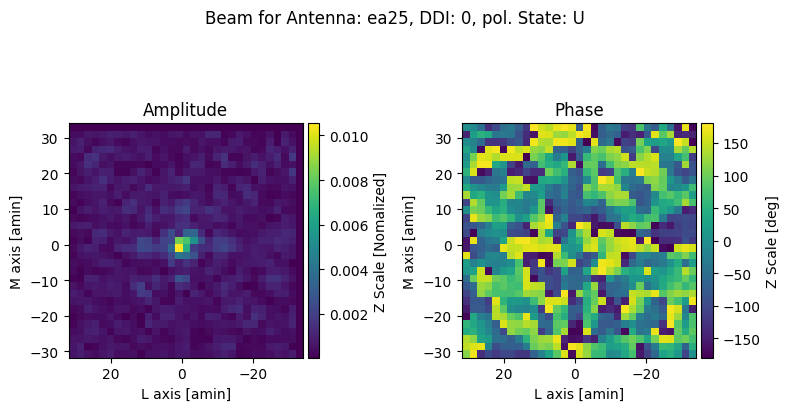

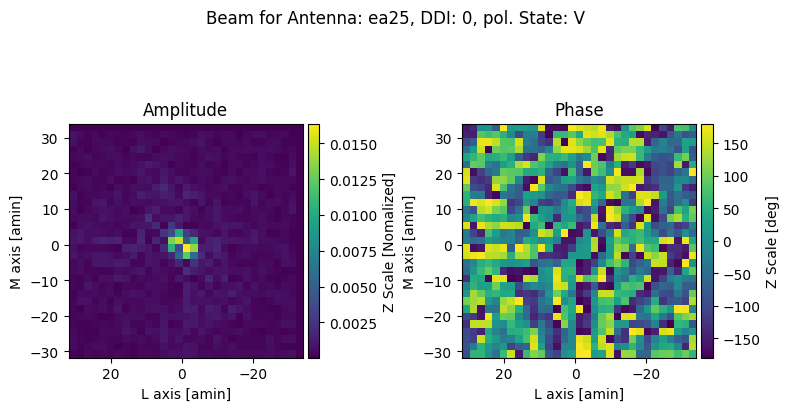

In [17]:
image_mds.plot_beams(
    image_exports,         # Directory to contain the plots
    ant='ea25',            # Plotting antenna ea25
    ddi=0,                 # Plotting DDI 0
    display=True,          # Display plots below
    angle_unit='amin',     # Unit for L and M axes
    complex_split='polar', # Plot amplitude and phase
    phase_unit='deg',      # Unit for phase
    parallel=False,        # Don't do plots in parallel
)

Here we call again `plot_beams`, this time over all the Antennas and the DDIs in the `image_mds`. For brevity the plots are not displayed, but a list of the files created is displayed just after the execution of `plot_beams`

In [18]:
image_mds.plot_beams(
    image_exports,         # Directory to contain the plots
    ant="all",             # Plotting all antennas
    ddi="all",             # Plotting all DDIs
    display=False,         # Don't display plots below
    complex_split='polar', # Plot amplitude and phase
    parallel=True,         # Do plots in parallel
)

# All exported files
print('\nCreated files:')

list_directory_files(image_exports+'/image_beam*.png')

[2025-03-26 16:12:11,543]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 



Created files:
image_exports/image_beam_polar_ant_ea06_ddi_0_pol_V.png
image_exports/image_beam_polar_ant_ea06_ddi_1_pol_V.png
image_exports/image_beam_polar_ant_ea25_ddi_0_pol_I.png
image_exports/image_beam_polar_ant_ea25_ddi_1_pol_Q.png
image_exports/image_beam_polar_ant_ea25_ddi_1_pol_V.png
image_exports/image_beam_polar_ant_ea06_ddi_0_pol_Q.png
image_exports/image_beam_polar_ant_ea06_ddi_0_pol_I.png
image_exports/image_beam_polar_ant_ea25_ddi_1_pol_I.png
image_exports/image_beam_polar_ant_ea06_ddi_0_pol_U.png
image_exports/image_beam_polar_ant_ea06_ddi_1_pol_I.png
image_exports/image_beam_polar_ant_ea06_ddi_1_pol_U.png
image_exports/image_beam_polar_ant_ea06_ddi_1_pol_Q.png
image_exports/image_beam_polar_ant_ea25_ddi_1_pol_U.png
image_exports/image_beam_polar_ant_ea25_ddi_0_pol_U.png
image_exports/image_beam_polar_ant_ea25_ddi_0_pol_Q.png
image_exports/image_beam_polar_ant_ea25_ddi_0_pol_V.png


### Plotting apertures

Apertures are the final product of `holog` and are the data that is used by `panel` to compute the screw adjustments. Before proceeding to `panel` we may want to inspect the amplitude and phase maps of the apertures.
Specifically the amplitude map may be used to estimate the value of the `cutoff` parameter of `panel`. In our first call to `plot_apertures` we are going to use a single antenna and DDI for display, followed by a call that goes over all antennas and DDIs and lists the created files.

[2025-03-26 16:12:17,012]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


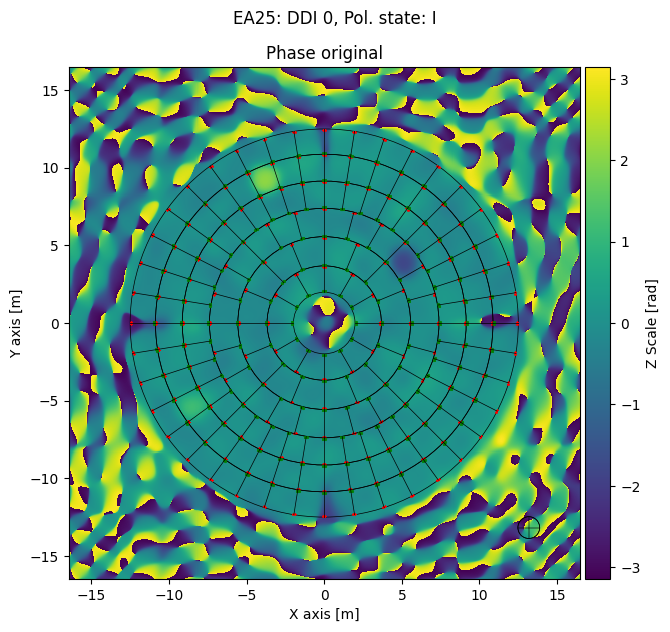

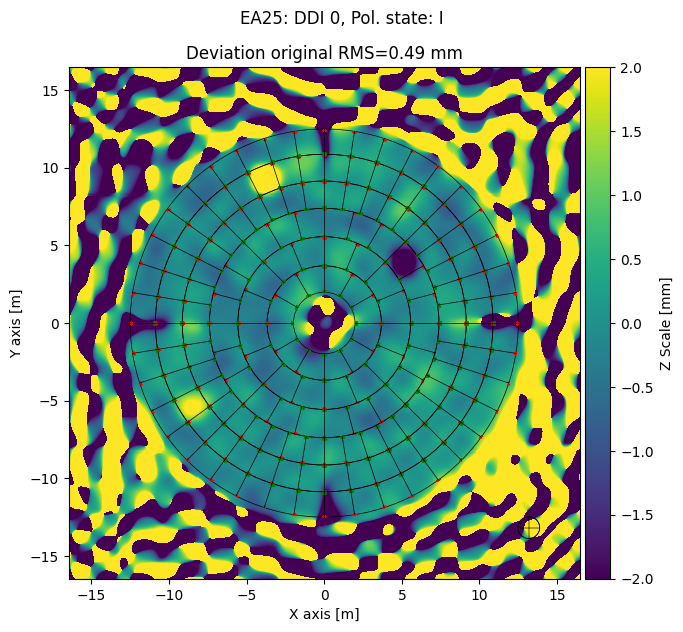

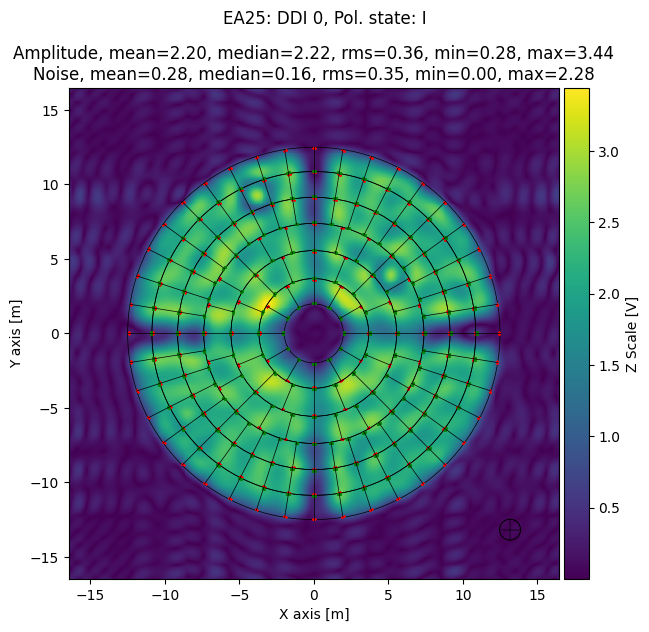

In [19]:
import numpy as np

image_mds.plot_apertures(
    image_exports,                # Directory to contain the plots
    ant='ea25',                   # Plotting antenna ea25
    ddi=0,                        # Plotting DDI 0
    polarization_state='I',       # Plot only Stokes I aperture 
    plot_screws=True,             # Plotting screw positions
    phase_unit='rad',             # Plotting phase as radians, degrees also possible (deg)
    phase_limits=[-np.pi, np.pi], # Plotting from -pi to pi
    deviation_unit='mm',          # Plotting deviation as mm, all length units available
    deviation_limits=[-2, 2],     # Plotting from -2 to 2 mm
    display=True,                 # Display plots below
    parallel=False,               # Don't do plots in parallel
)

In [20]:
image_mds.plot_apertures(
    image_exports,       # Directory to contain the plots
    ant="all",           # Plotting all antennas
    ddi="all",           # Plotting all DDIs
    plot_screws=True,    # Plotting screw positions
    display=False,       # Don't display plots below
    parallel=True,       # Do plots in parallel
)

# List All exported files
print('\nCreated files:')

list_directory_files(image_exports+'/image_amplitude*.png')
list_directory_files(image_exports+'/image_corrected*.png')

[2025-03-26 16:12:41,514]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 



Created files:


### Exporting image data to FITS

Sometimes it can be interesting to work with the data produced by `holog` in another astronomical software package such as `astropy` or `carta`. For this purpose we have introduced the method `export_to_fits` to the `image_mds` object. The FITS created by this routine encompass all the data arrays contained in each `xarray` dataset of the `image_mds`. After the execution of `export_to_fits` we display the list of created files and the header of one of the created files.

In [21]:
image_mds.export_to_fits(
    image_exports,             # Directory to contain FITS files
    complex_split='cartesian', # Data will be split into real and imaginary FITS files
    ant="all",                 # Export all antennas
    ddi="all",                 # Export all DDIs
    parallel=True              # Export FITS files in parallel
)

# All exported files
print('\nCreated files:')

list_directory_files(image_exports+'/image*.fits')

[2025-03-26 16:13:06,399]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


[2025-03-26 16:13:06,694]     INFO    worker_1:  Exporting image contents of ant_ea06 ddi_1 to FITS files in image_exports 


[2025-03-26 16:13:06,961]     INFO    worker_3:  Exporting image contents of ant_ea25 ddi_1 to FITS files in image_exports 
[2025-03-26 16:13:07,151]     INFO    worker_2:  Exporting image contents of ant_ea25 ddi_0 to FITS files in image_exports 


[2025-03-26 16:13:07,345]     INFO    worker_0:  Exporting image contents of ant_ea06 ddi_0 to FITS files in image_exports 

Created files:
image_exports/image_aperture_imag_ant_ea25_ddi_1.fits
image_exports/image_corrected_phase_ant_ea25_ddi_0.fits
image_exports/image_beam_real_ant_ea25_ddi_1.fits
image_exports/image_aperture_real_ant_ea06_ddi_0.fits
image_exports/image_aperture_imag_ant_ea25_ddi_0.fits
image_exports/image_beam_real_ant_ea06_ddi_1.fits
image_exports/image_beam_imag_ant_ea06_ddi_1.fits
image_exports/image_beam_real_ant_ea25_ddi_0.fits
image_exports/image_aperture_real_ant_ea25_ddi_0.fits
image_exports/image_corrected_phase_ant_ea25_ddi_1.fits
image_exports/image_beam_real_ant_ea06_ddi_0.fits
image_exports/image_aperture_imag_ant_ea06_ddi_1.fits
image_exports/image_corrected_phase_ant_ea06_ddi_1.fits
image_exports/image_corrected_phase_ant_ea06_ddi_0.fits
image_exports/image_beam_imag_ant_ea06_ddi_0.fits
image_exports/image_beam_imag_ant_ea25_ddi_1.fits
image_exports/im

In [22]:
# Antenna ea06 DDI 0 aperture real FITS header
from astropy.io import fits

hdul = fits.open(image_exports+'/image_aperture_real_ant_ea06_ddi_0.fits')
print(repr(hdul[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    4                                                  
EXTEND  =                    T                                                  
STOKES  = 'I, Q, U, V'                                                          
WAVELENG= 0.021161322651231735                                                  
FREQUENC=        14167000000.0                                                  
TELESCOP= 'ea06    '                                                            
INSTRUME= 'VLA     '        

### Exporting phase fit results from image data

Sometimes it is important to understand the what came of the phase fitting during the imaging process. This can be done using the `export_phase_fit_results` method of the `image_mds` objects.

In [23]:
image_mds.export_phase_fit_results(
    image_exports, # Directory to contain phase fit results
    ant="all",                 # Export all antennas
    ddi="all",                 # Export all DDIs
    parallel=True              # Export ASCII files in parallel
) 
                                   

[2025-03-26 16:13:07,560]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


In [24]:
with open(image_exports+'/image_phase_fit_ant_ea25_ddi_0.txt', 'r') as file:
    for line in file:
        print(line[:-1])

* map 0, Frequency 14.1670 GHz, polarization state I:

 +---------------------+-----------------+------+
| Parameter           |           Value | Unit |
+---------------------+-----------------+------+
| Phase offset        |      0.24 ± 0.0 | deg  |
| X point offset      |       0.0 ± 0.0 | deg  |
| Y point offset      | -0.000218 ± 0.0 | deg  |
| X focus offset      |     -0.65 ± 0.0 |  mm  |
| Y focus offset      |       1.9 ± 0.0 |  mm  |
| Z focus offset      |     0.081 ± 0.0 |  mm  |
| X subreflector tilt |  0.000114 ± 0.0 | deg  |
| Y subreflector tilt |  -0.00045 ± 0.0 | deg  |
| X cassegrain offset |     -28.0 ± 0.0 |  mm  |
| Y cassegrain offset |      25.0 ± 0.0 |  mm  |
+---------------------+-----------------+------+




## Panel: screw adjustments, plotting residuals corrections and exporting data to FITS

If we are sure about the quality of the data we can now proceed to getting screw adjustments and evaluating the surface provided by these adjustments. For that we are going to use the methods of the `panel_mds` object, i.e. the data product of the `panel` function.

### Run panel or open panel file

Here we check for the existence of a `.panel.zarr` file, if it does not exist we run `panel`, if it exists we open it with `open_panel`.

In [25]:
import os
from astrohack import panel, open_panel

panel_file = 'data/ea25_cal_small_after_fixed.split.panel.zarr'

if os.path.exists(panel_file):
    panel_mds = open_panel(panel_file)
    
else:
    panel_mds = panel(
        image_name=image_file,
        panel_model='rigid',
        panel_margins=0.2,
        clip_type='relative',
        clip_level=0.2,
        overwrite=True,
        parallel=True
    )


With the `panel_mds` in hands we can now explore its contents. As before we define a variable, this time called `panel_exports`, with the name of the directory to contain the exported products and we call the `summary` method to see the list of contents and available methods. In this tutorial we will cover the methods: `plot_antennas`, `export_screws` and `export_to_fits`.

In [26]:
panel_exports = 'panel_exports'
panel_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.panel.zarr                       ###
####################################################################################################

Full documentation for AstrohackPanelFile objects' API at: 
https://astrohack.readthedocs.io/en/stable/_api/autoapi/astrohack/mds/index.html#astrohack.mds.AstrohackPanelFile

Input Parameters:
+--------------------+--------------------------------------------------+
| Parameter          | Value                                            |
+--------------------+--------------------------------------------------+
| image_name         | data/ea25_cal_small_after_fixed.split.image.zarr |
| panel_name         | data/ea25_cal_small_after_fixed.split.panel.zarr |
| clip_type          | relative 

### Plotting antenna original deviation, residuals and corrections

Here we make a first call to `plot_antennas` to plot only the deviations for a single antenna and DDI for brevity, and then a second call to produce all possible plots for all the antennas and DDIs present in the `panel_mds`.
The deviation plots shown below serve to ilustrate the current state of the antenna surface, the proposed corrections to it, and the estimated residuals after the correction is applied to the antenna.

[2025-03-26 16:13:08,273]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


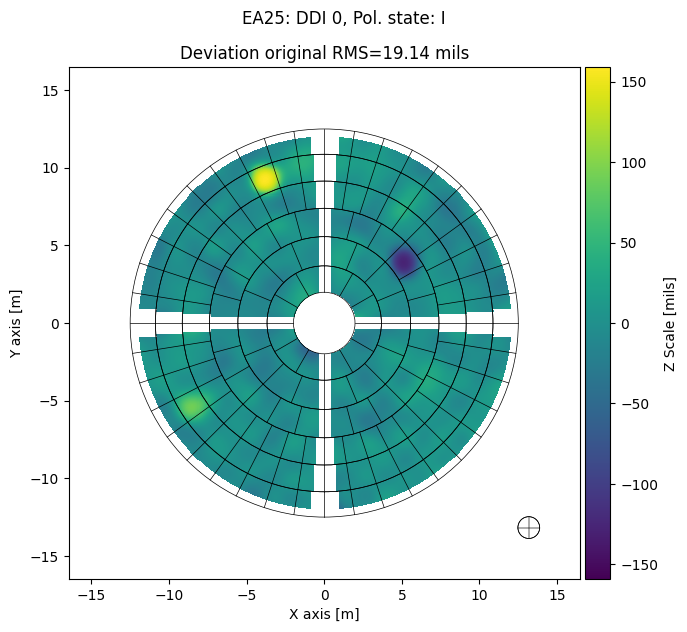

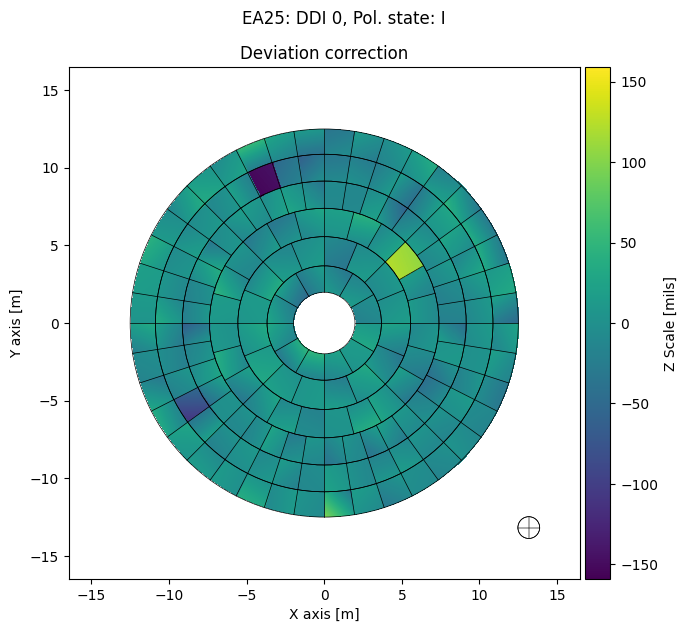

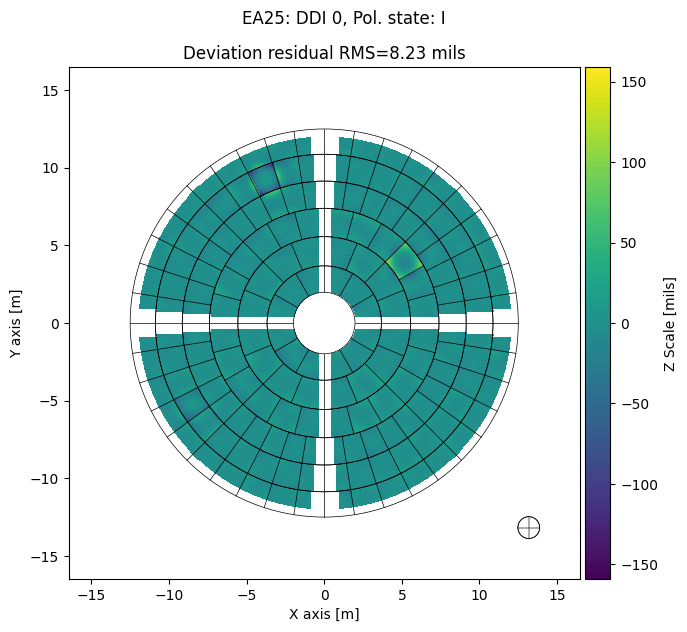

In [27]:
panel_mds.plot_antennas(
    panel_exports,           # Directory to contain the plot and text file
    ant='ea25',              # Plotting Antenna ea25
    ddi=0,                   # Plotting DDI 0
    plot_type='deviation',   # Do deviation plots only
    deviation_unit='mils',   #
    plot_screws=False,       # Not plotting screw positions
    parallel=False,          # Don't do plots in parallel
    display=True             # Display plots below
)

In [28]:
panel_mds.plot_antennas(
    panel_exports,           # Directory to contain the plot and text file
    ant="all",               # Plotting all antennas
    ddi="all",               # Plotting all DDIs
    plot_type='all',         # Do all possible plots
    plot_screws=False,       # Not plotting screw positions
    parallel=True,           # Do plots in parallel
    display=False            # Don't Display plots below
)

# All exported files
print('\nCreated files:')

list_directory_files(panel_exports+'/panel_mask*.png')
list_directory_files(panel_exports+'/panel_amplitude*.png')
list_directory_files(panel_exports+'/panel_deviation*.png')
list_directory_files(panel_exports+'/panel_phase*.png')


[2025-03-26 16:13:13,048]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 



Created files:
panel_exports/panel_mask_ant_ea25_ddi_0.png
panel_exports/panel_mask_ant_ea06_ddi_0.png
panel_exports/panel_mask_ant_ea06_ddi_1.png
panel_exports/panel_mask_ant_ea25_ddi_1.png
panel_exports/panel_amplitude_ant_ea06_ddi_1.png
panel_exports/panel_amplitude_ant_ea06_ddi_0.png
panel_exports/panel_amplitude_ant_ea25_ddi_1.png
panel_exports/panel_amplitude_ant_ea25_ddi_0.png
panel_exports/panel_deviation_correction_ant_ea06_ddi_0.png
panel_exports/panel_deviation_correction_ant_ea06_ddi_1.png
panel_exports/panel_deviation_original_ant_ea25_ddi_0.png
panel_exports/panel_deviation_residual_ant_ea25_ddi_0.png
panel_exports/panel_deviation_residual_ant_ea25_ddi_1.png
panel_exports/panel_deviation_original_ant_ea06_ddi_0.png
panel_exports/panel_deviation_original_ant_ea06_ddi_1.png
panel_exports/panel_deviation_residual_ant_ea06_ddi_0.png
panel_exports/panel_deviation_correction_ant_ea25_ddi_1.png
panel_exports/panel_deviation_correction_ant_ea25_ddi_0.png
panel_exports/panel_devi

### Screw adjustments

If we are satisfied with the proposed corrections we can then export them as a `txt` file and an acompaining helper plot. This can be done with the `panel_mds` method `export_screws`. Here we cover a single antenna and DDI for brevity.

[2025-03-26 16:13:24,433]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


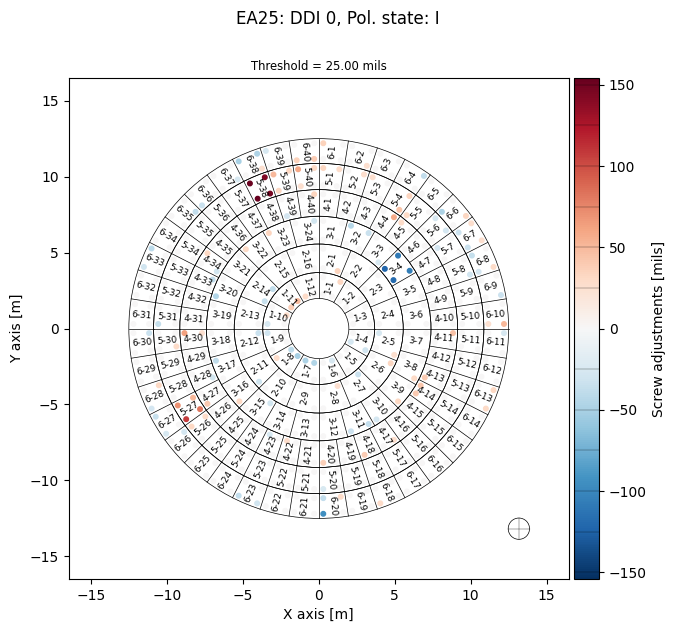

In [29]:
panel_mds.export_screws(
    panel_exports,            # Directory to contain the plot and text file
    unit='mils',              # Unit to express screw adjustments in plots and texts
    threshold= 25,            # Threshold in mils for significant adjustments
    display=True,             # Display plot below
    ant='ea25',               # Export screw adjustments for antenna ea25
    ddi=0                     # Export screw adjustments for ddi 0
)

Below we show an example of a `txt` file produced by `export_screws`

In [30]:
with open(panel_exports+'/panel_screws_ant_ea25_ddi_0.txt', 'r') as file:
    for _ in range(30):
        print(file.readline()[:-1])

# Screw adjustments for VLA's EA25: DDI 0, pol. state I
# Frequency = 14.1670 GHz
# Antenna surface RMS before adjustment: 19.14 mils or 0.49 mm
# Antenna surface RMS after adjustment: 8.23 mils or 0.21 mm
# Lower means away from subreflector
# Raise means toward the subreflector
# LOWER the panel if the number is POSITIVE
# RAISE the panel if the number is NEGATIVE
# Adjustments are in mils

# Panel      il        ir        ol        or    Fallback    Model
  1-1    -13.15      0.24      8.64     33.67      no       rigid
  1-2     -8.98    -15.91     15.91      2.96      no       rigid
  1-3     13.73     19.93     -0.28     11.30      no       rigid
  1-4    -15.70    -27.26     -9.05    -30.67      no       rigid
  1-5    -17.55    -11.67    -15.01     -4.01      no       rigid
  1-6    -25.61    -17.60     -1.30     13.68      no       rigid
  1-7    -45.80    -48.48     13.00      7.98      no       rigid
  1-8    -50.92    -40.21      7.68     27.70      no       rigid
  1-9    

### Exporting panel data to FITS

As with the `image_mds` data it may be convenient to export the data arrays in a `panel_mds` to FITS files.
This can be acomplished with the method `export_to_fits`. As before we export all the data in the `panel_mds`, display a list of the produced files and an example header of one of the created files.

In [31]:
panel_mds.export_to_fits(
    panel_exports,             # Directory to contain FITS files
    ant="all",                 # Export all antennas
    ddi="all",                 # Export all DDIs
    parallel=True              # Export FITS files in parallel
)

# All exported files
print("\nCreated files:")

list_directory_files(panel_exports+'/panel*.fits')

[2025-03-26 16:13:27,421]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


[2025-03-26 16:13:27,691]     INFO    worker_1:  Exporting panel contents of ant_ea25 ddi_1 to FITS files in panel_exports 


[2025-03-26 16:13:27,990]     INFO    worker_0:  Exporting panel contents of ant_ea06 ddi_0 to FITS files in panel_exports 
[2025-03-26 16:13:28,040]     INFO    worker_3:  Exporting panel contents of ant_ea25 ddi_0 to FITS files in panel_exports 


[2025-03-26 16:13:28,303]     INFO    worker_2:  Exporting panel contents of ant_ea06 ddi_1 to FITS files in panel_exports 

Created files:
panel_exports/panel_deviation_correction_ant_ea06_ddi_0.fits
panel_exports/panel_phase_original_ant_ea06_ddi_1.fits
panel_exports/panel_deviation_original_ant_ea25_ddi_0.fits
panel_exports/panel_phase_residual_ant_ea25_ddi_0.fits
panel_exports/panel_deviation_residual_ant_ea06_ddi_1.fits
panel_exports/panel_amplitude_ant_ea06_ddi_1.fits
panel_exports/panel_phase_residual_ant_ea06_ddi_0.fits
panel_exports/panel_phase_original_ant_ea25_ddi_1.fits
panel_exports/panel_deviation_correction_ant_ea25_ddi_1.fits
panel_exports/panel_mask_ant_ea25_ddi_1.fits
panel_exports/panel_amplitude_ant_ea25_ddi_0.fits
panel_exports/panel_phase_correction_ant_ea25_ddi_1.fits
panel_exports/panel_mask_ant_ea06_ddi_1.fits
panel_exports/panel_phase_correction_ant_ea06_ddi_1.fits
panel_exports/panel_phase_correction_ant_ea06_ddi_0.fits
panel_exports/panel_phase_original_ant_

In [32]:
# Antenna ea06 DDI 0 deviation residual FITS header
from astropy.io import fits

hdul = fits.open(panel_exports+'/panel_deviation_residual_ant_ea06_ddi_0.fits')
print(repr(hdul[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  510                                                  
NAXIS2  =                  510                                                  
EXTEND  =                    T                                                  
PMODEL  = 'rigid   '                                                            
PMARGIN =                  0.2                                                  
CLIP    =   0.7992535393524346                                                  
TELESCOP= 'ea06    '                                                            
INSTRUME= 'VLA     '                                                            
WAVELENG= 0.021161322651231735                                                  
FREQUENC=        14167000000

### Checking gain improvements

One important measure of antenna performance and panel adjustment sucess is the gain estimate derived from the aperture phases. Gain tables for the antennas for which holography was done can be obtained by using the `export_gain_tables` method of the `panel_mds` objects.

In [33]:
panel_mds.export_gain_tables(
    panel_exports,             # Directory to contain gain tables
    ant="all",                 # Export all antennas
    ddi="all",                 # Export all DDIs
    parallel=True              # Export ASCII files in parallel
)

[2025-03-26 16:13:28,481]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


In [34]:
with open(panel_exports+'/panel_gains_ant_ea25_ddi_0.txt', 'r') as file:
    for line in file:
        print(line[:-1])

# Gain estimates for VLA antenna ea25
# Based on a measurement at 14.1670 GHz, 2.12 cm
# Antenna surface RMS before adjustment: 0.49 mm
# Antenna surface RMS after adjustment: 0.21 mm

+-------------+------------+--------------+-------------+------------------+
|  Frequency  | Wavelength | Before panel | After panel | Theoretical Max. |
+-------------+------------+--------------+-------------+------------------+
|  1.4990 GHz |  20.00 cm  |   31.15 dB   |   31.15 dB  |     31.96 dB     |
|  2.3061 GHz |  13.00 cm  |   33.02 dB   |   33.02 dB  |     33.83 dB     |
|  4.9965 GHz |  6.00 cm   |   36.36 dB   |   36.38 dB  |     37.19 dB     |
|  9.9931 GHz |  3.00 cm   |   39.32 dB   |   39.38 dB  |     40.20 dB     |
| 14.9896 GHz |  2.00 cm   |   41.01 dB   |   41.12 dB  |     41.96 dB     |
| 23.0610 GHz |  1.30 cm   |   42.72 dB   |   42.96 dB  |     43.83 dB     |
| 29.9792 GHz |  1.00 cm   |   43.72 dB   |   44.06 dB  |     44.97 dB     |
| 42.8275 GHz |  7.00 mm   |   45.00 dB   |  